In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *
from additional_functions import *

Data loading
===

In [2]:
from proj1_helpers import *

labels, raw_data, indices = load_csv_data('train.csv', sub_sample=False)
# where b(background) -> -1 and s(signal) -> 1
n_samples, n_raw_features = np.shape(raw_data)
print(f'Dimension: {np.shape(raw_data)}')

Dimension: (250000, 30)


Data preprocessing
===

In [3]:
# A vector contaning the indices of features from raw_data kept for analysis:
feature_indices = []

In [4]:
# Converting meaningless -999 to NaN, computing NaN proportion and remove feature with too many missing 
# values (NaN): unlikely to carry much useful information (TO BE DISCUSSED):

NaN_prop = 0.3
reduced_data = remove_meaningless_features(raw_data, NaN_prop)
n_samples, n_reduced_features = np.shape(reduced_data)
print(f'Dimension: {np.shape(reduced_data)}')

Removed features : [4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
Dimension: (250000, 20)


In [5]:
#We can also standardize the data (TO BE DISCUSSED):

std_data = standardize(reduced_data)
# reshape tx to add offset, ones... c_
print(std_data)

[[ 3.26639375e-01  4.74908629e-02  3.27299021e-01 ...  9.62248666e-01
   2.00729544e-02  7.95041942e-01]
 [ 7.68418827e-01  3.83992032e-01  4.33639132e-01 ... -8.89795721e-01
   4.09472351e-04 -5.27740161e-01]
 [ 0.00000000e+00  2.22063991e+00  8.80354118e-01 ...  9.95302980e-01
   4.09472351e-04 -5.66575538e-01]
 ...
 [-3.22511159e-01  2.21925612e-01 -1.05061623e-01 ... -2.14138813e-01
   4.09472351e-04 -6.10995344e-01]
 [-5.29095702e-01 -5.87501964e-01 -2.43236912e-01 ... -1.90891467e+00
  -1.92540097e-02 -1.43670428e+00]
 [ 0.00000000e+00  4.62409998e-01 -2.03536341e-01 ... -2.17069461e+00
  -1.92540097e-02 -1.43670428e+00]]


Features exploration and selection
===

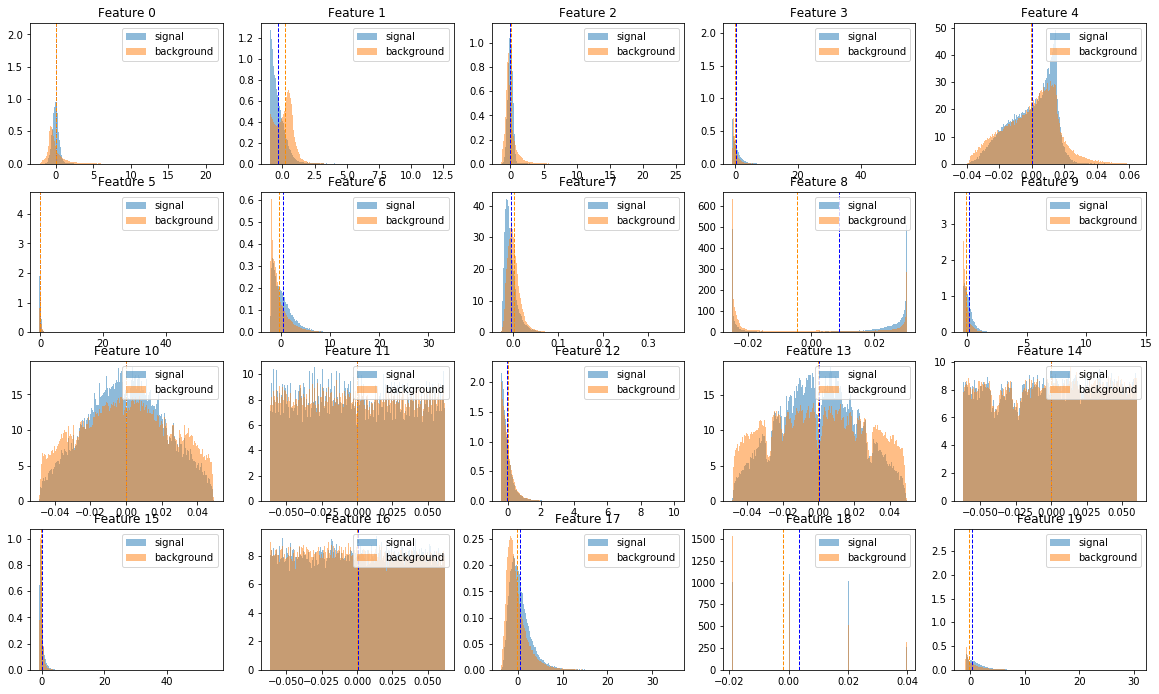

In [7]:
#Let's look at the distribution of each remaining feature:
s_data = std_data[labels == 1,:]
bg_data = std_data[labels == -1,:]
n_samples, n_features = np.shape(std_data)

plt.figure(figsize=(20,15))
peaks = 200

for i in range(n_features):
    plt.subplot(5,5,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], peaks, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], peaks, density=1, alpha=0.5, label='background')
    plt.axvline(s_data[:,i][~np.isnan(s_data[:,i])].mean(), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(bg_data[:,i][~np.isnan(bg_data[:,i])].mean(), color='darkorange', linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.title(f'Feature {i}') 

Feature reduction
===

In [12]:
# Mean discrimination

threshold_mean = 0.05 #if background mean < 5% (TO BE DISCUSSED)
for i in range(n_features):
    #mean comparison between classes normalized wrt/ feature mean
    diff_mean = (np.abs(np.abs((s_data[:,i]).mean()) - np.abs((bg_data[:,i]).mean()))) / np.abs((std_data[:,i]).mean()) 
    if diff_mean < threshold_mean:
        print('Mean difference:', i, s_data[:,i].mean(), bg_data[:,i].mean(), diff_mean)

# Useless features : 2,4,5,12,15

In [13]:
# Low variance filter : data columns with too little changes carry little information

threshold_var = 1.0e-04 #value TO BE DISCUSSED
variances = np.var(std_data, axis = 0) / np.linalg.norm(std_data, axis = 0)
for i in range(n_features):
    if variances[i] < threshold_var:
        print('Low variance:', i, variances[i])
        
# Useless features: 4,7,8,10,11,13,14,16,18,20,21

Low variance: 4 3.078945592612374e-05
Low variance: 7 3.3221109068626193e-05
Low variance: 8 4.693997418094349e-05
Low variance: 10 4.7745931910394886e-05
Low variance: 11 7.144763224180461e-05
Low variance: 13 4.974780812357872e-05
Low variance: 14 7.14416631457962e-05
Low variance: 16 7.126907471655635e-05
Low variance: 18 3.8439132404942e-05


In [15]:
# High correlation filter : data columns with similar trends carry similar information

correlation_pairs = np.ones((2,2))
for i in range(n_features):
    for j in range(n_features):
        correlation_pairs = np.corrcoef(std_data[:,i],std_data[:,j])
        if correlation_pairs[0,1] > 0.85 and i != j:
            print("Feature = {f1} and Feature = {f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i], std_data[:,j]))
            
# Results: highly correlated > 0.85 (value TO BE DISCUSSED)
# Ex.: features 6 and 17; 6 and 19; 17 and 19...
# Useless feature = 17, 19 as highly correlated to 

Feature = 6 and Feature = 17 [[1.         0.90448146]
 [0.90448146 1.        ]]
Feature = 6 and Feature = 19 [[1.         0.96562839]
 [0.96562839 1.        ]]
Feature = 17 and Feature = 6 [[1.         0.90448146]
 [0.90448146 1.        ]]
Feature = 17 and Feature = 19 [[1.         0.88441286]
 [0.88441286 1.        ]]
Feature = 19 and Feature = 6 [[1.         0.96562839]
 [0.96562839 1.        ]]
Feature = 19 and Feature = 17 [[1.         0.88441286]
 [0.88441286 1.        ]]


In [16]:
#We thus have reduced our features
reduced_data = np.delete(std_data, np.s_[4,7,8,10,11,13,14,16,17,18,20,21,22], axis=1)
print(f'Dimension: {np.shape(reduced_data)}')

Dimension: (250000, 10)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


Kept features: 6
Shape of PCA_data: (250000, 6)


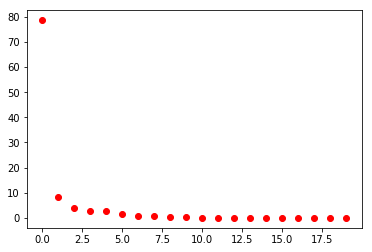

In [26]:
#Principal component analysis - would replace high correlation filter

variance_threshold = 0.98
eig_val, eig_vec, var = PCA(std_data, variance_threshold)
PCA_data = std_data.dot(eig_vec) #i.e. decorrelated data
print('Shape of PCA_data:', np.shape(PCA_data))
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], var, 'ro')

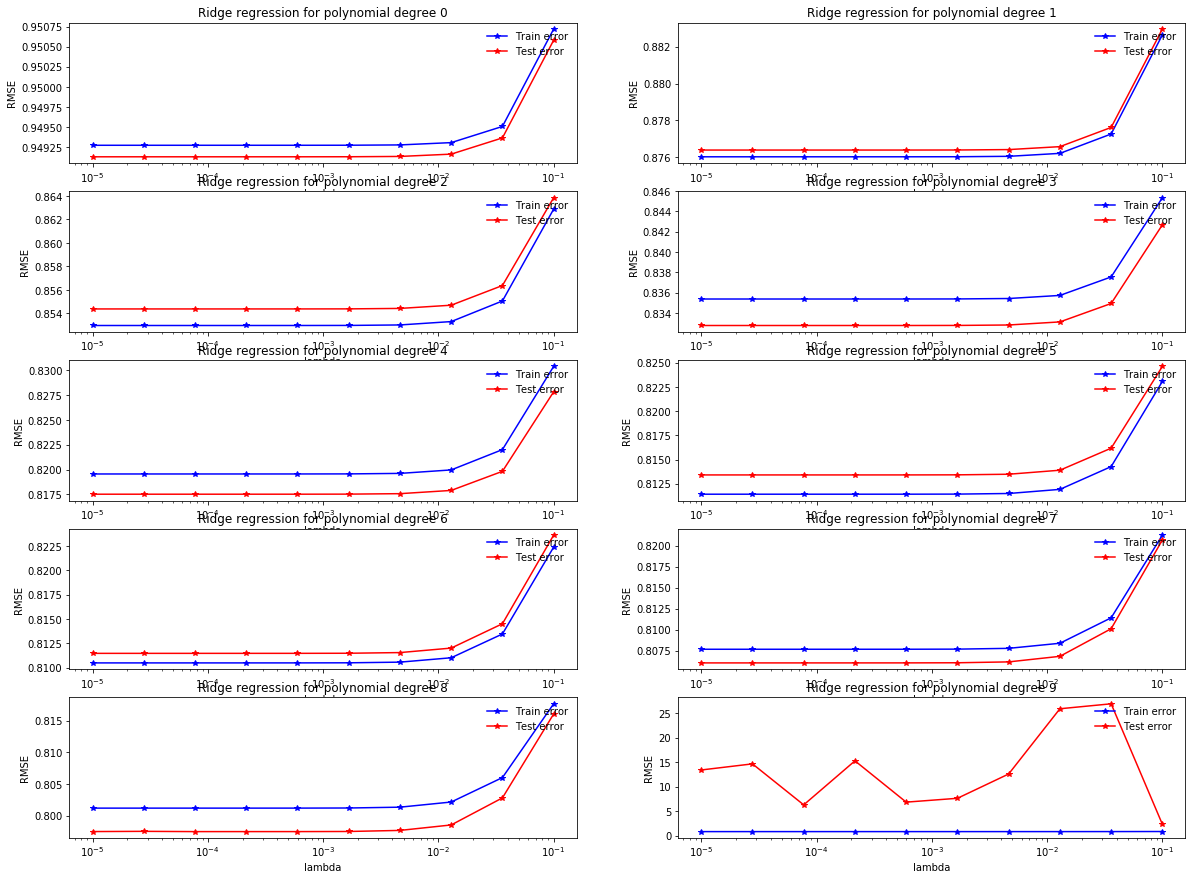

In [23]:
#Ridge regression trial
seed = 56
split_ratio = 0.5
plt.figure(figsize = (20,15))

for degree in range(10):
    plt.subplot(5, 2, degree+1)
    ridge_regression_demo(PCA_data, labels, degree, split_ratio, seed)

In [ ]:
# Ridge regression outcome: polynomial of degree 8

Submission trials
===

In [51]:
#Submission with ridge_regression
#Parameters

chosen_lambda = 0.001
chosen_degree = 8
NaN_prop = 0.3

#I have some problems here....
 
# 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
# 0 1 2 3       4 5 6  7  8    9   10 11 12 13 14 15 16 17 18 19 20 21         22
# 0 1 2 3         4 5           6         7        8           9       

#Build the model (weights)
reduced_data_poly = build_poly(PCA_data, chosen_degree)
std_data_poly = standardize(reduced_data_poly)
weights, loss = ridge_regression(labels, std_data_poly, chosen_lambda)

#Load the test set
labels_te, tx_te, indices_te = load_csv_data('test.csv', sub_sample=False)

#Preprocessing
clean_tx_te = remove_meaningless_data(tx_te, NaN_prop)
std_tx_te = standardize(tx_te)

#PCA - dimension reduction
eig_val_te, eig_vec_te, var_te = PCA(std_tx_te, variance_threshold)
PCA_data_te = std_tx_te.dot(eig_vec_te)
reduced_data_poly_te = build_poly(PCA_data_te, chosen_degree)
std_data_poly_te = standardize(reduced_data_poly_te)

#needed_weights = np.zeros(30)
#positions = [0,1,2,3,8,9,13,16,19,23]
#for i in range(10):
#    needed_weights[positions[i]] = weights[i]
#print(needed_weights)


Removed features : [4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
Kept features: 7


In [52]:
# Make prediction
print(weights.shape)
print(std_data_poly)

y_pred = predict_labels(weights, PCA_data_te)
create_csv_submission(indices_te, y_pred, 'submission_ridge_1.csv')

(49,)
[[ 0.00000000e+00  1.30155231e-11  5.17905197e-12 ... -1.28893131e-02
  -1.58727198e-06 -1.62292402e-06]
 [ 0.00000000e+00 -1.30003509e-11  9.45717374e-12 ... -1.28893131e-02
  -1.58727227e-06 -1.62292402e-06]
 [ 0.00000000e+00  7.06233496e-12  1.37257153e-11 ... -1.28893130e-02
  -1.58426529e-06 -1.62281968e-06]
 ...
 [ 0.00000000e+00 -1.05524903e-11 -2.42006825e-12 ... -1.28893131e-02
  -1.58727227e-06 -1.62292402e-06]
 [ 0.00000000e+00 -3.51534677e-11 -6.90867352e-12 ... -1.28893131e-02
  -1.58727225e-06 -1.62292402e-06]
 [ 0.00000000e+00 -3.34183890e-11  5.56767123e-13 ... -1.28893131e-02
  -1.58727226e-06 -1.62292402e-06]]


ValueError: shapes (568238,7) and (49,) not aligned: 7 (dim 1) != 49 (dim 0)